In [433]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

from IPython.display import display, HTML
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime

In [434]:
def extract(string, key, dtype):
    if dtype is bool:
        return True if re.search(' {}=((True)|(False)) '.format(key), string).group(1) == 'True' else False
    if dtype is float:
        return float(re.search(' {}=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?)'.format(key), string).group(1))
    if dtype is int:
        return float(re.search(' {}=(\d+) '.format(key), string).group(1))

def get_result_metrics(filepath):
    # get lines with results
    lines = []
    marker = 'Got result: '
    with open(filepath) as f:
        for line in f.readlines():
            if marker in line:
                lines.append(line.split(marker, 1)[1])
    
    # extract metrics
    runs = []
    for run in lines:
        data = {
            #'success': extract(run, 'success', bool),
            'time_created': extract(run, 'time_created', float),
            'time_input_received': extract(run, 'time_input_received', float),
            'time_compute_started': extract(run, 'time_compute_started', float),
            'time_result_sent': extract(run, 'time_result_sent', float),
            'time_result_received': extract(run, 'time_result_received', float),
            'time_running': extract(run, 'time_running', float),
            'time_serialize_inputs': extract(run, 'time_serialize_inputs', float),
            'time_deserialize_inputs': extract(run, 'time_deserialize_inputs', float),
            'time_serialize_results': extract(run, 'time_serialize_results', float),
            'time_deserialize_results': extract(run, 'time_deserialize_results', float),
            'time_result_received': extract(run, 'time_result_received', float),
        }
        

        
        data['client_to_method_server'] = data['time_input_received'] - (
                data['time_created'] + data['time_serialize_inputs'])
        data['worker_to_method_server'] = data['time_result_sent'] - (
                data['time_compute_started'] + data['time_running'] + 
                data['time_deserialize_inputs'] + data['time_serialize_results'])
        data['method_server_to_client'] = data['time_result_received'] - (
                data['time_result_sent'] + data['time_deserialize_results'])
        data['time_serialization'] = sum(data[key] for key in data if 'serialize' in key)
        data['time_created_to_result_received'] = data['time_result_received'] - data['time_created']
        
        runs.append(data)
    
    return pd.DataFrame(runs)

def aggregate_runs(run_paths):
    data = []
    for path in run_paths:
        results = pd.Series({'path': path})

        with open(path) as f:
            first_line = f.readline()
            timestamp = first_line.split(' - ')[0]
            value_server = True if re.search('use_value_server=(.+),', first_line).group(1) == 'True' else False
            results['value_server'] = value_server
            results['task_count'] = int(re.search('task_count=(\d+),', first_line).group(1))
            results['task_input_size'] = int(re.search('task_input_size=(\d+),', first_line).group(1))
            results['task_interval'] = float(re.search('task_interval=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?),', first_line).group(1))
            results['task_output_size'] = int(re.search('task_output_size=(\d+),', first_line).group(1))
            results['time_start'] = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S,%f").timestamp()
            
            to_proxy_times = []
            for line in f.readlines():
                if 'to_proxy_time=' in line:
                    to_proxy_times.append(extract(line, 'to_proxy_time', float))
            results['to_value_server_time'] = np.median(to_proxy_times) if len(to_proxy_times) > 0 else 0

        function_results = get_result_metrics(path)
        results['n_tasks'] = len(function_results.index)
        results['total'] = None
        results = pd.concat([results, function_results.median()])
                
        data.append(results)
        
    return pd.concat(data, axis=1).T

In [435]:
cols = ['client_to_method_server', 'worker_to_method_server', 'method_server_to_client', 'time_serialization', 'to_value_server_time', 'time_running', 'total']
ind = np.arange(len(cols))
width = 0.35

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/unique_data_async/2021-02-12_22-12-11/run...,True,100,10,1,0,1.61317e+09,0.000331402,100,0.006853,...,0.00121096,4.276e-05,0.000165997,0.000315108,5.36995e-05,0.000596523,0.00365233,0.000475645,0.000586116,0.941826
1,runs/unique_data_async/2021-02-12_22-14-29/run...,False,100,10,1,0,1.61317e+09,0,100,0.005914,...,4.632e-05,6.80355e-05,0.000300757,0.000423584,6.75035e-05,0.000670195,0.00371826,0.000595808,0.000883105,67.3309


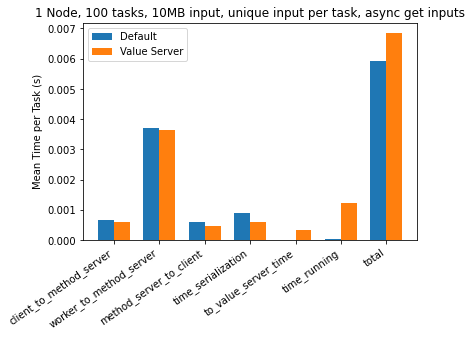

In [436]:
rundir = 'runs/unique_data_async/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 10MB input, unique input per task, async get inputs')
plt.ylabel('Mean Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/unique_data/2021-02-12_22-20-32/runtime.log,False,100,10,1,0,1.61317e+09,0,100,0.006588,...,5.16905e-05,6.8138e-05,0.000297927,0.000421974,8.05445e-05,0.000660419,0.00420296,0.000787854,0.000885,0.021425
1,runs/unique_data/2021-02-12_22-23-15/runtime.log,True,100,10,1,0,1.61317e+09,0.000359535,100,0.006586,...,0.00114288,4.0805e-05,0.000165216,0.000317723,4.9351e-05,0.000588179,0.00350714,0.000406742,0.000581166,41.2877


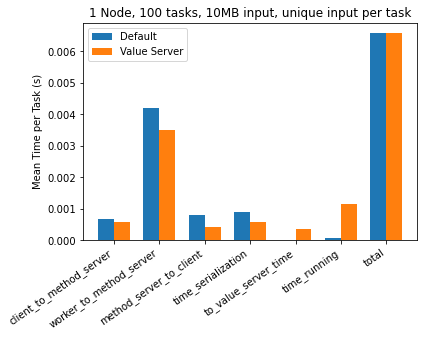

In [437]:
rundir = 'runs/unique_data/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 10MB input, unique input per task')
plt.ylabel('Mean Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/reuse_data/2021-02-12_23-05-08/runtime.log,True,100,10,1,0,1.61317e+09,0.000184178,100,0.006499,...,0.00123897,3.2831e-05,0.000168646,0.000311482,4.6155e-05,0.00041151,0.00367665,0.000415802,0.000571809,54.922
1,runs/reuse_data/2021-02-12_23-07-14/runtime.log,False,100,10,1,0,1.61317e+09,0,100,0.005645,...,5.284e-05,6.39065e-05,0.000303232,0.000428733,6.33025e-05,0.000486732,0.00367475,0.000563622,0.000866758,83.1781


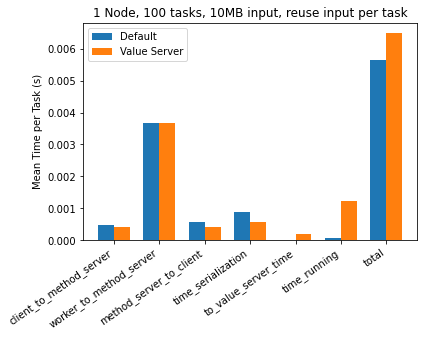

In [438]:
rundir = 'runs/reuse_data/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 100 tasks, 10MB input, reuse input per task')
plt.ylabel('Mean Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,time_created,time_input_received,time_compute_started,time_result_sent,time_result_received,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received,to_value_server_time
0,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.145912,0.000101,0.111102,0.000506,0.000094,1.703667,0.146913,0.001837,0.111803,102.772487,0.000184
1,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,0.001378,0.000052,0.000174,0.000309,0.000088,0.706002,0.004879,0.000708,0.000622,102.430779,0.000184
2,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,0.001511,0.000043,0.000156,0.000312,0.000077,0.000464,0.004876,0.000632,0.000588,101.450753,0.000184
3,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,0.001392,0.000045,0.000170,0.000309,0.000077,0.000786,0.004279,0.000668,0.000602,100.469376,0.000184
4,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,0.001376,0.000047,0.000169,0.000308,0.000058,0.000556,0.004148,0.000646,0.000582,99.488751,0.000184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,0.001175,0.000038,0.000171,0.000321,0.000061,0.000547,0.003744,0.000393,0.000591,10.334869,0.000184
96,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,0.001353,0.000038,0.000178,0.000316,0.000065,0.000499,0.003716,0.000479,0.000597,9.355312,0.000184
97,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,0.001171,0.000037,0.000159,0.000318,0.000044,0.000448,0.004084,0.000382,0.000558,8.374996,0.000184
98,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,1.613171e+09,0.001166,0.000036,0.000174,0.000318,0.000046,0.000721,0.003983,0.000531,0.000574,7.395107,0.000184


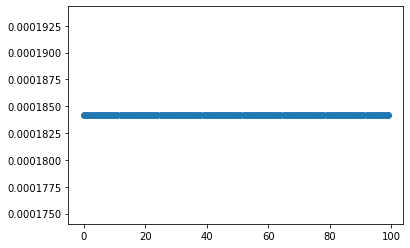

In [439]:
rundir = 'runs/reuse_data/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = get_result_metrics(run_paths[0])

to_proxy_times = []
with open(run_paths[0]) as f:
    for line in f.readlines():
        if 'to_proxy_time=' in line:
            to_proxy_times.append(extract(line, 'to_proxy_time', float))
results['to_value_server_time'] = np.median(to_proxy_times) if len(to_proxy_times) > 0 else 0

display(results)

# no_value_server = results.loc[results['value_server'] == False][cols]
# value_server = results.loc[results['value_server'] == True][cols]

fig, ax = plt.subplots()
plt.scatter(range(len(results)), results['to_value_server_time'])
# plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
# plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

# plt.title('1 Node, 100 tasks, 10MB input, unique input per task')
# plt.ylabel('Mean Time per Task (s)')
# ax.set_xticks(ind + width/2) 
# ax.set_xticklabels(cols, ha="right", rotation=35)
# plt.legend(loc='best')
# plt.show()